In [1]:
from leftright_mccamley_py_master.Library import utils
from gaitlink.data import LabExampleDataset
import matplotlib.pyplot as plt
import numpy as np
from leftright_mccamley_py_master.Library import array_handling
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn import metrics

from tqdm.notebook import tqdm

In [2]:
from gaitlink.data import load_mobilised_matlab_format, get_all_lab_example_data_paths

subject = ("HA", "001")

all_example_data_paths = get_all_lab_example_data_paths()
example_participant_path = all_example_data_paths[subject]
data_with_reference_stereo = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="Stereophoto")
data_with_reference_indip = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="INDIP")

test_list = list(data_with_reference_stereo.keys())
test_list

[('TimeMeasure1', 'Test5', 'Trial1'),
 ('TimeMeasure1', 'Test5', 'Trial2'),
 ('TimeMeasure1', 'Test11', 'Trial1')]

In [3]:
# stereo data check
print('Stereo reference data:')
for test_no in range(len(test_list)):
    no_gs = len(data_with_reference_stereo[test_list[test_no]].reference_parameters['lwb'])
    print(f'For test {test_list[test_no]}, there are {no_gs} GS detected.')
print('\n')
print('INDIP reference data:')
for test_no in range(len(test_list)):
    no_gs = len(data_with_reference_indip[test_list[test_no]].reference_parameters['lwb'])
    print(f'For test {test_list[test_no]}, there are {no_gs} GS detected.')

Stereo reference data:
For test ('TimeMeasure1', 'Test5', 'Trial1'), there are 1 GS detected.
For test ('TimeMeasure1', 'Test5', 'Trial2'), there are 1 GS detected.
For test ('TimeMeasure1', 'Test11', 'Trial1'), there are 6 GS detected.


INDIP reference data:
For test ('TimeMeasure1', 'Test5', 'Trial1'), there are 1 GS detected.
For test ('TimeMeasure1', 'Test5', 'Trial2'), there are 1 GS detected.
For test ('TimeMeasure1', 'Test11', 'Trial1'), there are 6 GS detected.


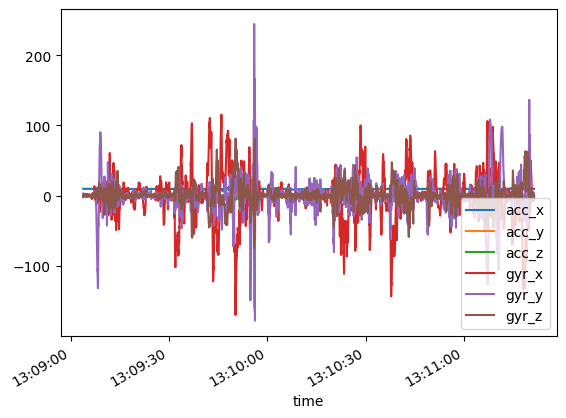

In [4]:
example_participant_path = all_example_data_paths[subject]
data_with_reference = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="INDIP")

# notes: the stereophoto IC reference data for HA, 002, test_list[1] is not great

test_list = list(data_with_reference_stereo.keys())
test_no = 2

imu_data = data_with_reference[test_list[test_no]].imu_data['LowerBack']

# get the sampling rate
sampling_rate = data_with_reference[test_list[test_no]].metadata.sampling_rate_hz

imu_data.plot()
plt.legend(loc = 'lower right')

In [8]:
gs = 5
data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]

{'Start': 119.9,
 'End': 125.17,
 'StrideFrequency': 47.9163465483544,
 'Cadence': 95.8326930967088,
 'Duration': 5.269999999999996,
 'Length': 3.5147347096394546,
 'WalkingSpeed': 0.8806321349801776,
 'AverageStrideLength': 1.0215756016872968,
 'NumberStrides': 6.0,
 'Turning_Flag': 1.0,
 'TerminationReason': 'Pause',
 'Break_Start': array([], dtype=float64),
 'Break_End': array([], dtype=float64),
 'Break_Duration': array([], dtype=float64),
 'Break_Number': 0.0,
 'Turn_Start': array([122.91, 123.69, 124.42]),
 'Turn_End': array([123.69, 124.42, 125.17]),
 'Turn_Duration': array([0.78, 0.73, 0.75]),
 'Turn_Number': 3.0,
 'Turn_Angle': array([-80.19600245,  46.22280122, -50.32647815]),
 'Turn_NumberStrides': array([2., 1., 1.]),
 'Turn_AngularVelocity': array([array([ 4.37872563,  5.73625621,  7.15801458,  8.64288006, 10.189448  ,
               11.79600228, 13.46048886, 15.18049077, 16.95320498, 18.77542163,
               20.64350605, 22.55338414, 24.5005314 , 26.47996631, 28.486248

### Data handling utility function
______
The following utility function will output all the gait sequences of a gait test, along with reference IC locations.
* For now, the utility function does not output turns, it only provides linear walking reference data.

__TODO: We need to decide how we are going to handle NaNs.__

In [5]:
# let's start with test_no = 2, gs = 3
test_no = 2
gs = 2 # no NaNs here

reference_data = data_with_reference[test_list[test_no]].reference_parameters['lwb']

# checking the number of turns
turns = []
for gs in range(len(reference_data)):
    print(f"GS #{gs} contains {reference_data[gs]['Turn_Number']} turns.")
    turns.append(reference_data[gs]['Turn_Number'])

# checking for NaNs:
for gs in range(len(reference_data)):
    if True in np.isnan(reference_data[gs]['InitialContact_Event']):
        print(f"GS #{gs} contains NaNs in the IC sequence")

for gs in range(len(reference_data)):
    if True in pd.isna(reference_data[gs]['InitialContact_LeftRight']):
        print(f"GS #{gs} contains NaNs in the L/R sequence")       

GS #0 contains 0.0 turns.
GS #1 contains 0.0 turns.
GS #2 contains 2.0 turns.
GS #3 contains 2.0 turns.
GS #4 contains 0.0 turns.
GS #5 contains 3.0 turns.


In [6]:
def extract_sequence_data(imu_data, reference_data):
    """
    Utility function for extracting the sequences of linear and curvilinear data.
    Args:
        imu_data: - pandas dataframe containing the IMU data
        reference_data: - a list of dictionaries containing the reference data
    Returns:
        data_list: - list of numpy arrays containing the data for each sequence
        sequence_label: - list of strings containing the label for each sequence, 'linear' or 'curvilinear'
        ic_list: - list of numpy arrays containing the IC indices for each sequence, 0 indexed, relative to the start of the corresponding sequence of 'linear' or 'curvilinear' data
        lr_list: - list of numpy arrays containing the L/R labels for each sequence
    """
    signal = imu_data.loc[:, ['gyr_x', 'gyr_y', 'gyr_z']].to_numpy()
    # preallocate the list names, this is going to be the output
    walking_type_label = []
    sequence_no = []
    data_list = []
    ic_list = []
    lr_list = []
    
    # how many GS are detected?
    for gs in range(len(reference_data)):
        print(f"GS number {gs} is being processed.")
        # getting the start and end points of the GS and turns, if any
        gs_start = np.array([reference_data[gs]['Start']])
        gs_end = np.array([reference_data[gs]['End']])
        turn_start = np.array(reference_data[gs]['Turn_Start'])
        turn_end = np.array(reference_data[gs]['Turn_End'])
        # remove the duplicates from the turn array, this means that you are patching consecutive turns

        duplicate_start = np.isin(turn_start, turn_end)
        duplicate_end = np.isin(turn_end, turn_start)
        clean_turn_start = turn_start[~duplicate_start]
        # print(clean_turn_start)
        clean_turn_end = turn_end[~duplicate_end]
        # print(clean_turn_end)

        turn_array = np.sort(np.hstack((clean_turn_start, clean_turn_end)))

        # TODO: here you can check if gs_start and gs_end are in turn_array. If they are, that means that the sequence is starting or ending with a turn. Then you can remove the duplicate.

        if turn_start.shape[0] != 0:
            if gs_start[0] == turn_start[0]:
                # print('GS starting with curvilinear walking')
                case = 0
            else:
                # print('GS stating with linear walking')
                case = 1
            # not relevant, but only for informative purposes
            # if gs_end[0] == turn_end[-1]:
            #     print('GS ending with curvilinear walking')
            #     # case = 2
            # else:   
            #     print('GS NOT ending with linear walking')
            #     # case = 3
        else:
            case = 1
        
        alternating_array = np.append(np.concatenate((gs_start, turn_array)), gs_end)
        alternating_array = np.round(alternating_array * sampling_rate).astype(int)
        alternating_array = np.unique(alternating_array)
        # print(alternating_array)

        # I know that these are alternating sequences of linear and curvilinear walking

        start = np.round(alternating_array[0] * sampling_rate).astype(int) 
        end = np.round(alternating_array[-1] * sampling_rate).astype(int)
        ic_all = np.round(reference_data[gs]['InitialContact_Event'] * sampling_rate).astype(int)
        lr_all = reference_data[gs]['InitialContact_LeftRight']

        n_label = 0

        for segments in range(len(alternating_array) - 1):
            if case == 0:
                # GS starting with curvilinear walking
                if segments % 2 == 1:
                    walking_type_label.append(f'Linear gs #{gs}')
                    sequence_no.append(gs)
                    sequence_start = alternating_array[segments]
                    sequence_end = alternating_array[segments + 1]
                    data_list.append(signal[sequence_start : sequence_end, :])        
                    # get the IC indices and labels from within this sequence window
                    # indices
                    ic_sequence =  ic_all[(ic_all >= sequence_start) & (ic_all <= sequence_end)] - sequence_start
                    ic_list.append(ic_sequence)
                    # labels
                    no_ics = len(ic_sequence)
                    lr = lr_all[n_label: n_label + no_ics]
                    n_label += no_ics
                    lr_list.append(lr)       
                else:
                    walking_type_label.append(f'Curvilinear gs #{gs}')
                    sequence_no.append(gs)
                    sequence_start = alternating_array[segments]
                    sequence_end = alternating_array[segments + 1]
                    data_list.append(signal[sequence_start : sequence_end, :])
                    # get the IC indices and labels from within this sequence window
                    # indices
                    ic_sequence =  ic_all[(ic_all >= sequence_start) & (ic_all <= sequence_end)] - sequence_start
                    ic_list.append(ic_sequence)
                    # labels
                    no_ics = len(ic_sequence)
                    lr = lr_all[n_label: n_label + no_ics]
                    n_label += no_ics
                    lr_list.append(lr)        
            elif case == 1 :
                # GS starting with linear walking
                if segments % 2 == 0:
                    walking_type_label.append(f'Linear gs #{gs}')
                    sequence_no.append(gs)
                    sequence_start = alternating_array[segments]
                    sequence_end = alternating_array[segments + 1]
                    data_list.append(signal[sequence_start : sequence_end, :])        
                    # get the IC indices and labels from within this sequence window
                    # indices
                    ic_sequence =  ic_all[(ic_all >= sequence_start) & (ic_all <= sequence_end)] - sequence_start
                    ic_list.append(ic_sequence)
                    # labels
                    no_ics = len(ic_sequence)
                    lr = lr_all[n_label: n_label + no_ics]
                    n_label += no_ics
                    lr_list.append(lr)       
                else:
                    walking_type_label.append(f'Curvilinear gs #{gs}')
                    sequence_no.append(gs)
                    sequence_start = alternating_array[segments]
                    sequence_end = alternating_array[segments + 1]
                    data_list.append(signal[sequence_start : sequence_end, :])
                    # get the IC indices and labels from within this sequence window
                    # indices
                    ic_sequence =  ic_all[(ic_all >= sequence_start) & (ic_all <= sequence_end)] - sequence_start
                    ic_list.append(ic_sequence)
                    # labels
                    no_ics = len(ic_sequence)
                    lr = lr_all[n_label: n_label + no_ics]
                    n_label += no_ics
                    lr_list.append(lr)
                    
    return data_list, walking_type_label, sequence_no, ic_list, lr_list

In [7]:
# testing the function
imu_data = data_with_reference[test_list[test_no]].imu_data['LowerBack']
reference_data = data_with_reference[test_list[test_no]].reference_parameters['lwb']

data_list, walking_type_label, sequence_no,  ic_list, lr_list = extract_sequence_data(imu_data, reference_data)

GS number 0 is being processed.
GS number 1 is being processed.
GS number 2 is being processed.
GS number 3 is being processed.
GS number 4 is being processed.
GS number 5 is being processed.


In [9]:
lr_list

[array(['Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left'],
       dtype=object),
 array(['Right', 'Left', 'Right', 'Left', 'Right', 'Left'], dtype=object),
 array(['Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right',
        'Left'], dtype=object),
 array(['Right', 'Left', 'Right', 'Left'], dtype=object),
 array(['Right', 'Left', 'Right', 'Left', 'Right'], dtype=object),
 array(['Right', 'Left'], dtype=object),
 array(['Right', 'Left', 'Right', 'Right', 'Left', 'Right'], dtype=object),
 array(['Left', 'Right', 'Left', 'Right', 'Left'], dtype=object),
 array(['Right', 'Left', 'Right'], dtype=object),
 array(['Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left'],
       dtype=object),
 array(['Right', 'Left', 'Right', 'Left', 'Right', 'Left'], dtype=object),
 array(['Right', 'Left'], dtype=object)]

In [59]:
# len(reference_data)
# reference_data[5]
# sequence_no
len_ic_list = [len(ic_list[i]) for i in range(len(ic_list))]
sum(len_ic_list)

63

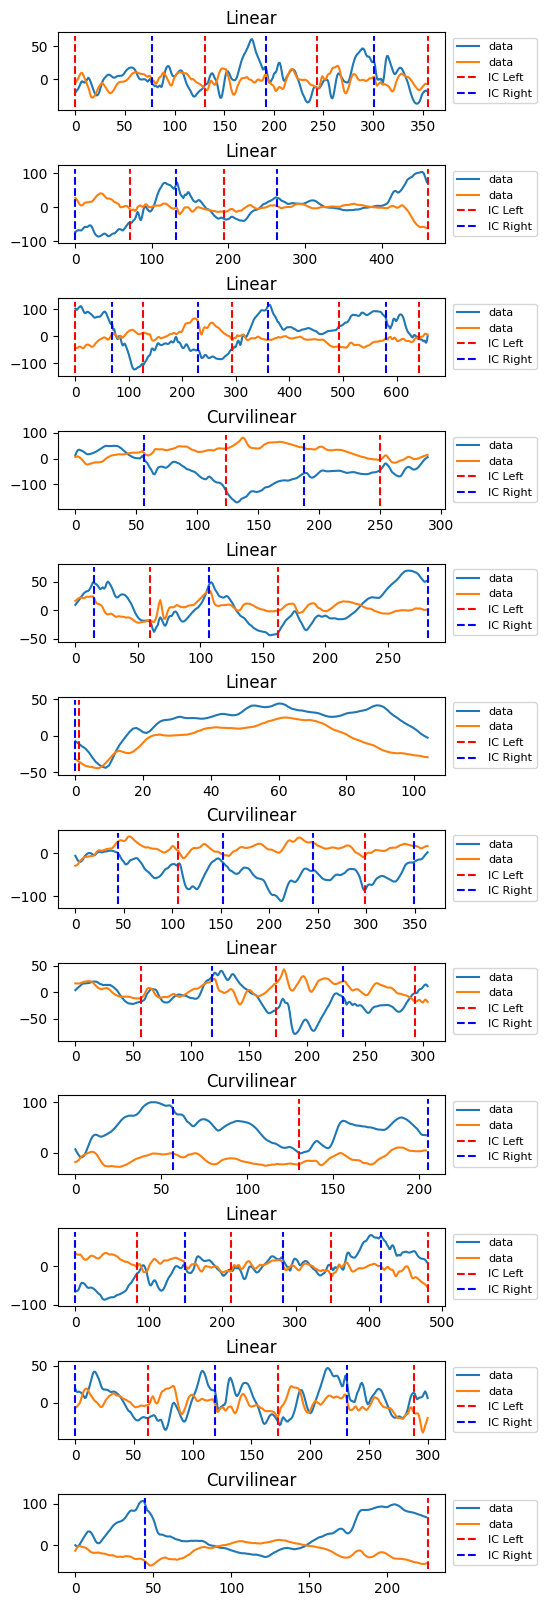

In [13]:
s = 3

plt.figure(figsize = (5, 20))
for s in range(len(data_list)):
    data = data_list[s]
    ics = ic_list[s]
    lr = lr_list[s]
    title = sequence_label[s]
    plt.subplot(len(data_list), 1, s + 1)
    plt.plot(data, label = 'data')
    ax = plt.gca()
    ylimits = ax.get_ylim()
    plt.vlines(ics[lr == 'Left'], ymin = ylimits[0], ymax = ylimits[1], color = 'r', linestyles='dashed', label = 'IC Left')
    plt.vlines(ics[lr == 'Right'], ymin = ylimits[0], ymax = ylimits[1], color = 'b', linestyles='dashed', label = 'IC Right')
    plt.title(title)
    plt.subplots_adjust(hspace=0.7)
    plt.legend(fontsize = 8, loc = 'upper right', bbox_to_anchor=(1.25, 1))

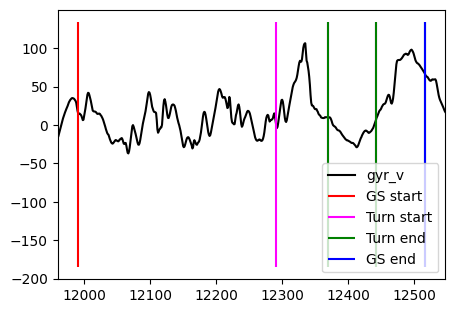

In [14]:
gs_start = data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['Start']
gs_end = data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['End']
gs_turn_start = data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['Turn_Start']
gs_turn_end = data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['Turn_End']

y = imu_data.loc[:, ['gyr_x']].to_numpy()

plt.figure(figsize = (5, 3.5))
plt.plot(y, 'k-', label = 'gyr_v')

ax = plt.gca()
ylimits = ax.get_ylim()

plt.vlines(x = np.array(gs_start) * sampling_rate, ymin = ylimits[0], ymax = ylimits[1], color = 'red', label = 'GS start')
plt.vlines(x = np.array(gs_turn_start) * sampling_rate, ymin = ylimits[0], ymax = ylimits[1], color = 'magenta', label = 'Turn start')
plt.vlines(x = np.array(gs_turn_end) * sampling_rate, ymin = ylimits[0], ymax = ylimits[1], color = 'green', label = 'Turn end')
plt.vlines(x = np.array(gs_end) * sampling_rate, ymin = ylimits[0], ymax = ylimits[1], color = 'blue', label = 'GS end')

plt.xlim(gs_start * sampling_rate - 30, gs_end * sampling_rate + 30)
plt.legend(loc = 'lower right')

# plt.fill_between(x = np.linspace(gs_start, gs_turn_start, 10) * sampling_rate,
#                 y1 = ylimits[0],
#                 y2 = ylimits[1],
#                 color = 'royalblue',
#                 alpha = 0.5,
#                 label = 'linear walk')
# plt.fill_between(x = np.linspace(gs_turn_start, gs_turn_end, 10) * sampling_rate,
#                 y1 = ylimits[0],
#                 y2 = ylimits[1],
#                 color = 'lightcoral',
#                 alpha = 0.5,
#                 label = 'turn')
# plt.fill_between(x = np.linspace(gs_turn_end, gs_end, 10) * sampling_rate,
#                 y1 = ylimits[0],
#                 y2 = ylimits[1],
#                 color = 'royalblue',
#                 alpha = 0.5)

In [218]:
print(gs_turn_start * sampling_rate)
print(gs_turn_end * sampling_rate)

[4513. 4564.]
[4564. 4803.]


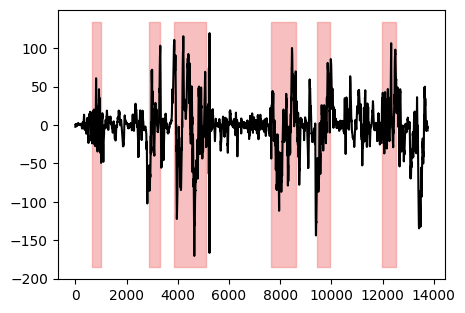

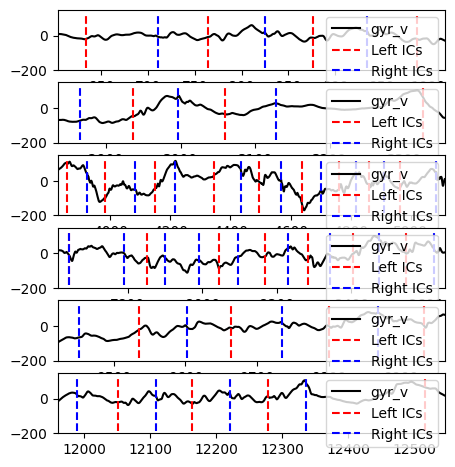

In [46]:
# TODO: let's deal with the turning flags.

signal = imu_data.loc[:, 'gyr_x'].to_numpy()

# gait sequences GSs
gs_start = [data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['Start'] for gs in range(len(data_with_reference[test_list[test_no]].reference_parameters['lwb']))]
gs_end = [data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['End'] for gs in range(len(data_with_reference[test_list[test_no]].reference_parameters['lwb']))]

# initial contacts within the GSs
reference_ics = [data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['InitialContact_Event'] for gs in range(len(data_with_reference[test_list[test_no]].reference_parameters['lwb']))]
ground_truth_ics = [data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['InitialContact_LeftRight'] for gs in range(len(data_with_reference[test_list[test_no]].reference_parameters['lwb']))]

# any turns?
turns = np.round([data_with_reference[test_list[test_no]].reference_parameters['lwb'][gs]['Turning_Flag'] for gs in range(len(data_with_reference[test_list[test_no]].reference_parameters['lwb']))]).astype(int)


plt.figure(figsize = (5, 3.5))
plt.plot(signal, color = 'black')

# get y_limits
ax = plt.gca()
ylimits = ax.get_ylim()

for gs in range(len((gs_start))):
    plt.fill_between(x = np.linspace(gs_start[gs], gs_end[gs], 10) * sampling_rate,
                    y1 = ylimits[0],
                    y2 = ylimits[1],
                    color = 'lightcoral',
                    alpha = 0.5)

if len(gs_start) == 1:
    plt.figure(figsize = (5, 3.5))
else:
    plt.figure(figsize = (5, 5.5))
for gs in range(len(gs_start)):
    plt.subplot(len(gs_start), 1, gs + 1)
    plt.plot(signal, color = 'black', label = 'gyr_v')
    plt.xlim(gs_start[gs] * sampling_rate - 30, gs_end[gs] * sampling_rate + 30)

    plt.vlines(reference_ics[gs][ground_truth_ics[gs] == 'Left'] * sampling_rate, ymin = ylimits[0], ymax = ylimits[1], color = 'red', linestyles = 'dashed', label = 'Left ICs' )
    plt.vlines(reference_ics[gs][ground_truth_ics[gs] == 'Right'] * sampling_rate, ymin = ylimits[0], ymax = ylimits[1], color = 'blue', linestyles = 'dashed', label = 'Right ICs')
    plt.legend(loc = 'upper right')

In [62]:
# signal = imu_data.loc[:, 'gyr_x'].to_numpy()

# gs_no = 2
# start = np.round(gs_start[gs_no] * sampling_rate).astype(int)
# end = np.round(gs_end[gs_no] * sampling_rate).astype(int)

# # Check for NaNs, if present throw error.
# nans = np.isnan(reference_ics[gs_no])
# assert all(item == False for item in nans), 'NaN instances present in the IC list provided. This will result in errors.'

# corrected_ics = np.round(reference_ics[gs_no] * sampling_rate).astype(int) - start
# # corrected_ics[nans] = np.nan()

# plt.figure(figsize = (5, 3.5))
# plt.plot(signal[start : end], 'k-')
# plt.vlines(corrected_ics, ymin = -20, ymax = 20, colors='red', linestyles='dashed')

# This seems to be fine.

### ML Methods Playground
___
Pre processing required:

1) Filter the $gyr_{v}$ and $gyr_{ap}$ signals
2) Get the filtered signals values @ IC location
3) Additionally, get the first and second derivatives @ IC locations

You should now have a feature matrix of size $N \times 6$, where $N$ is the total number of ICs detected.

* The final step in the pre-processing phase is to min-max normalize the feature vector.

In [8]:
def preprocessing_ml(gyr_3d, sampling_rate):
    # extract vertical and anterior-posterior components
    gyr_v = gyr_3d[:, 0]
    gyr_ap = gyr_3d[:, 2]
    
    # deprecated version using the lowpass filter.
    
    # bandpass filter to smoothen the signal and lower boundatry to remove offset
    lower_band = 0.5
    upper_band = 2
    gyr_v_filtered = utils._butter_bandpass_filter(gyr_v, 
                                                   lower_bound = lower_band,
                                                   upper_bound = upper_band,
                                                   sampling_rate_hz = sampling_rate)
    
    gyr_ap_filtered = utils._butter_bandpass_filter(gyr_ap, 
                                                   lower_bound = lower_band,
                                                   upper_bound = upper_band,
                                                   sampling_rate_hz = sampling_rate)
    
    # compute the first derivative
    gyr_v_diff = np.diff(gyr_v_filtered)
    gyr_ap_diff = np.diff(gyr_ap_filtered)
    
    # compute the second derivative
    gyr_v_diff_2 = np.diff(gyr_v_diff)
    gyr_ap_diff_2 = np.diff(gyr_ap_diff)
    
    # output everything into a dictionary
    signal_dict = {}
    signal_dict['v_raw'] = gyr_v_filtered
    signal_dict['v_gradient'] = gyr_v_diff
    signal_dict['v_diff_2'] = gyr_v_diff_2
    
    signal_dict['ap_raw'] = gyr_ap_filtered
    signal_dict['ap_gradient'] = gyr_ap_diff
    signal_dict['ap_diff_2'] = gyr_ap_diff_2
    
    return signal_dict

def extract_features(signal_dict, ic_list, sampling_rate):
    """
    Feature extraction: extract the respective values at the IC samples from the six signals
    """
    
    # convert IC from seconds to samples
    # TODO: Can we assume that the IC list is already in sample format?
    # ic_list_samples = np.round(ic_list * sampling_rate).astype(int)
    
    # check that the last IC is at least 3 samples away from the end of the signal, so that we can compute the second derivative.
    if ic_list[-1] >= len(signal_dict['v_raw']):
        # shift the last IC by 3 samples:
        ic_list[-1] -= 3
        
    # get the feature values at the IC samples:
    feature_dict = {}
    feature_dict['v_raw'] = signal_dict['v_raw'][ic_list]
    feature_dict['v_gradient'] = signal_dict['v_gradient'][ic_list]
    feature_dict["v_diff_2"] = signal_dict["v_diff_2"][ic_list]

    feature_dict["ap_raw"] = signal_dict["ap_raw"][ic_list]
    feature_dict["ap_gradient"] = signal_dict["ap_gradient"][ic_list]
    feature_dict["ap_diff_2"] = signal_dict["ap_diff_2"][ic_list]

    feature_df = pd.DataFrame(feature_dict)    
    
    return feature_df

def plot_lr_results():
    """
    Plotting utility function for development purposes.
    """
    return 0

def evaluate_lr_results():
    """
    Evaluation utility function for development purposes.
    """
    return 0

In [83]:
# ok, so something is going on here....

# signal = imu_data.loc[:, ['gyr_x', 'gyr_y', 'gyr_z']].to_numpy()

# gs_no = 2
# start = np.round(gs_start[gs_no] * sampling_rate).astype(int)
# end = np.round(gs_end[gs_no] * sampling_rate).astype(int)

# # Check for NaNs, if present throw error.
# nans = np.isnan(reference_ics[gs_no])
# assert all(item == False for item in nans), 'NaN instances present in the IC list provided. This will result in errors.'

# corrected_ics = np.round(reference_ics[gs_no] * sampling_rate).astype(int) - start
# # print(start - start, end - start, corrected_ics)

# sd_gyro = signal[start : end]
# this is prepared for some ML tasks...

In [9]:
data_list, sequence_label, ic_list, reference_lr_list = extract_sequence_data(imu_data, reference_data)

GS number 0 is being processed.
GS number 1 is being processed.
GS number 2 is being processed.
GS number 3 is being processed.
GS number 4 is being processed.
GS number 5 is being processed.


In [10]:
segment = 2
sd_gyro = data_list[segment]

signal_dict = preprocessing_ml(sd_gyro, sampling_rate)
reference_lr_list[segment]

array(['Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right',
       'Left'], dtype=object)

In [180]:
len(reference_data[2]['InitialContact_LeftRight'])

18

In [69]:
sequence_no

[0, 1, 2, 2, 2, 3, 3, 3, 3, 4, 5, 5]

In [134]:
array_to_cut = [len(ic_list[i]) for i in range(len(ic_list))]

for i in range(1, len(array_to_cut)):
    array_to_cut[i] += array_to_cut[i - 1]
array_to_cut

[7, 13, 22, 26, 31, 33, 39, 44, 47, 55, 61, 63]

In [87]:
unique, counts = np.unique(sequence_no, return_counts = True)
print(unique, counts)

[0 1 2 3 4 5] [1 1 3 4 1 2]


In [249]:
feet = ['right' for i in range(63)]
xx = np.arange(0, array_to_cut[-1])

xx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [248]:
slices = {}
current_start = 0

for i in range(len(array_to_cut)):
    start = current_start
    end = array_to_cut[i]
    slice_number = sequence_no[i]

    if slice_number not in slices:
        slices[slice_number] = []

    slice_elements = xx[start:end]
    slices[slice_number].extend(slice_elements)

    current_start = array_to_cut[i]

result_slices = [slices[key] for key in sorted(slices.keys())]
sliced_lists = [[feet[i] for i in indices] for indices in result_slices]


# int_list = [int(x) for x in result_slices[0]]
# int_list
# slices.values()

[['right', 'right', 'right', 'right', 'right', 'right', 'right'],
 ['right', 'right', 'right', 'right', 'right', 'right'],
 ['right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right'],
 ['right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right'],
 ['right', 'right', 'right', 'right', 'right', 'right', 'right', 'right'],
 ['right', 'right', 'right', 'right', 'right', 'right', 'right', 'right']]

In [120]:
xx = np.linspace(1, 63, 63)
count_low = 0
k = 0
samples = []
for i in range(len(xx)):
    if i == array_to_cut[k]:
        print(i)
        k += 1
        # put all the samples until this point in a list
        count_upper = i
        samples.append(xx[count_low : count_upper])
        count_low = count_upper
samples

7


[array([1., 2., 3., 4., 5., 6., 7.])]

In [258]:
reference_data[3]['InitialContact_LeftRight']

array(['Right', 'Left', 'Right', 'Left', 'Right', 'Right', 'Left',
       'Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left',
       'Right'], dtype=object)

In [94]:
df_test = pd.DataFrame()

for segment in range(len(data_list)):
    signal_dict = preprocessing_ml(data_list[segment], sampling_rate)
    df_features = extract_features(signal_dict, ic_list[segment], sampling_rate)
    # adding the labels column
    df_features['foot'] = reference_lr_list[segment]
    # df_features['foot'] = np.nan
    df_test = pd.concat([df_test, df_features], ignore_index = True)
    
    # pd.concat([df_test, df_features])
df_test

,v_raw,v_gradient,v_diff_2,ap_raw,ap_gradient,ap_diff_2,foot
0,-2.090115,0.346523,-0.003467,1.213668,-0.567790,-0.023777,Left
1,-4.304332,-0.208825,0.067894,4.743889,-0.279176,0.014876,Right
2,-21.533867,-0.152510,0.091277,-3.602434,-0.080337,0.036697,Left
3,20.332211,-1.211451,-0.006017,-2.878913,-0.005652,0.020576,Right
4,-24.671493,-0.219499,0.078669,0.075775,0.191869,0.022887,Left
...,...,...,...,...,...,...,...
58,-31.133766,-0.472314,0.145642,-2.480182,0.497338,0.011790,Left
59,14.871819,-0.613299,-0.022891,0.262318,-0.049883,0.006686,Right
60,-2.734508,0.244669,-0.003716,-1.019034,0.022391,0.007156,Left
61,42.708268,-1.530008,-0.189446,-17.027061,-0.483510,0.063530,Right


In [317]:
# convert the 'foot' column to int type
df_labels = pd.DataFrame(df_test['foot'] == 'Right').astype(int)
df_features = df_test.drop(columns = ['foot'])
df_labels.head()

,foot
0,0
1,1
2,0
3,1
4,0


In [318]:
with open('ml_test_data.pkl', 'wb') as file:
    pickle.dump({'features': df_features, 'labels': df_labels}, file)

In [35]:
def test(a, b, **kwargs):
        pretrained = kwargs.get('pretrained')
        model = kwargs.get('model')   
        patient_group = kwargs.get('patient_group')
        
        print(len(kwargs))
        print(pretrained)
# test(1, 2, pretrained = 200, plm = 100)     
test(1, 2)     


0
None


In [101]:
# scaling the features

scaler = MinMaxScaler()
x_train = scaler.fit_transform(df_features)
y_train = df_labels.to_numpy()
# x_test = scaler.transform(x_test)

In [102]:
# defining classifiers and grid search for parameter tuning

def get_param_grid_svm_lin():
    # SVM linear
    # here, the parameter C is analogous to (the inverse of) a regularization coefficient because it controls the trade-off between training errors and model complexity.
    param_grid_svm_lin = [
        {'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 5, 7.5, 10, 25, 50, 100, 500, 1000, 5000, 10000],
         'kernel': ['linear']}
    ]
    return param_grid_svm_lin

def get_param_grid_svm_rbf():
    # SVM rbf
    param_grid_svm_rbf = [ 
        {'C': [1, 2.5, 5, 7.5, 10, 25, 50, 100, 500, 1000, 5000, 10000],
         'gamma': [2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.001, 0.0001],
         'kernel': ['rbf']},
    ]
    return param_grid_svm_rbf

def get_param_grid_knn():
    # KNN
    param_grid_knn = [
    {'n_neighbors': [2,5,7,10,15,20,30,40,60,100]},     
    ]
    return param_grid_knn

def param_grid_rfc(): # rfc = random forest classifier
    # Random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]


    # Create the random grid
    param_grid_rfc = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'max_features': max_features,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                    }

    return param_grid_rfc

In [103]:
# SVM Linear
from sklearn import svm
svm_lin = svm.SVC()
param_grid_svm_lin = get_param_grid_svm_lin()

# SVM RBF
from sklearn import svm
svm_rbf = svm.SVC()
param_grid_svm_rbf = get_param_grid_svm_rbf()

# kNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier()
param_grid_knn = [
  {'n_neighbors': [3,5,7,9,11,13,15,17]},     
]

# Random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
n_estimators = [100]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [None, 10, 20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
param_grid_rfc = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
               'min_samples_split': min_samples_split}
#                 'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [104]:
# check training shapes
print(x_train.shape)
print(df_labels.to_numpy().shape)

(9, 6)
(9, 1)


In [305]:
# ok, where can we get the trained parameters now?

# svm_lin example

classifier_list = [{"name": "svm_lin", "classifier": svm_lin,
                    "grid": param_grid_svm_lin},
                   {"name": "svm_rbf", "classifier": svm_rbf,
                    "grid": param_grid_svm_rbf},
                   {"name": "knn", "classifier": knn,
                    "grid": param_grid_knn}, 
                   {"name": "rfc", "classifier": rfc, "grid":
                       param_grid_rfc}]

acc_list = []
best_estimator_list = []
best_params_list = []
results_dict = []
i = 0

for classifier in classifier_list:

    model = classifier["classifier"]
    grid = classifier["grid"]
    clf_name = classifier["name"]

    # x_train, y_train = df_labels
    grid_cv = GridSearchCV(model, grid, cv=3, scoring = 'accuracy')
    # TODO: what is that cv parameter doing?
    # Answer: cv is an integer, used to specify the number of folds in a (Stratified)KFold
    
    grid_cv.fit(x_train, y_train.ravel())
    y_pred = grid_cv.predict(x_train)
    
    results_dict.append(grid_cv.cv_results_)
    acc_list.append(metrics.accuracy_score(y_train, y_pred.ravel()))
    best_estimator_list.append(grid_cv.best_estimator_)
    best_params_list.append(grid_cv.best_params_)

c:\Users\mer20as\Documents\PhD_Repos\gaitlink\.venv\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mer20as\Documents\PhD_Repos\gaitlink\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\mer20as\Documents\PhD_Repos\gaitlink\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mer20as\Documents\PhD_Repos\gaitlink\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\mer20as\Documents\PhD_Repos\gaitlink\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_

In [306]:
results_dict[0].keys() # this should be 7 dimensional, since we are feeding 7 parameters.
# however, I do not think that a grid search is the best optimization method. Might be better do other types of optimization, something like SMO, maybe?

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [307]:
results_dict[1]['params']

[{'C': 1, 'gamma': 2, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 1.5, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.75, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.25, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.075, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.05, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 2, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 1.5, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 0.75, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 0.5, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 0.25, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 0.075, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 0.05, 'kernel': 'rbf'},
 {'C': 2.5, 'gamma': 0.025, 'kernel': 'rbf'},
 {

In [310]:
acc_list

[1.0, 1.0, 0.8888888888888888, 1.0]

In [309]:
best_estimator_list

# ok, so this is only computing parameters from a grid search. This is not optimal...

[SVC(C=25, kernel='linear'),
 SVC(C=100, gamma=0.1),
 KNeighborsClassifier(n_neighbors=3),
 RandomForestClassifier()]

In [281]:
best_params_list[2]

{'n_neighbors': 3}

In [111]:
best_model = svm.SVC(C = best_params_list[1]['C'],
                     gamma = best_params_list[1]['gamma'],
                     kernel = best_params_list[1]['kernel'])

In [283]:
# let's have a look at the pretrained models - this is just an example.
import joblib

model_path = "C:\\Users\\mer20as\\Documents\\PhD_Repos\\gaitlink\\leftright_ml-master\\models\\uniss_unige_pd_model.gz"

trained_model = joblib.load(model_path)

c:\Users\mer20as\Documents\PhD_Repos\gaitlink\.venv\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 0.23.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [284]:
trained_model

SVC(C=1, kernel='linear')

In [224]:
trained_model.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# 1) TODO: provide an utility tool to train your models on different datasets?

# 2) TODO: utils: convert mat to dict - is this necessary?

# 4) TODO: put everything into a dataframe.

In [285]:
trained_model.predict(x_train)

array([0, 0, 1, 0, 1, 1, 0, 0, 0])

### SVM Playground
_____
Utility functions for plotting decision boundaries.

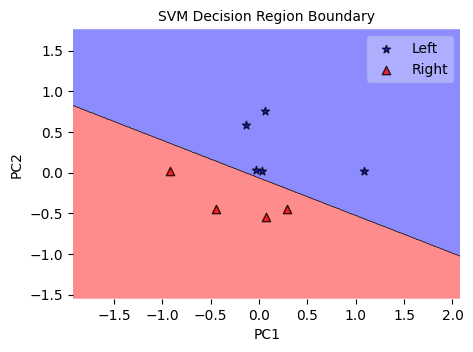

In [229]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

# ------------------ Plotting ------------------
#           Left foot = 0, Right foot = 1
# ------------------ Plotting ------------------

# linear svm
# svm_classifier = svm.SVC(C = best_params_list[0]['C'],
#                      kernel = best_params_list[0]['kernel'])

# rbf svm
svm_classifier = svm.SVC(C = best_params_list[1]['C'],
                     gamma = best_params_list[1]['gamma'],
                     kernel = best_params_list[1]['kernel'])

svm_classifier = trained_model

knn_classifier = neighbors.KNeighborsClassifier(n_neighbors = best_params_list[2]['n_neighbors'])

pca = PCA(n_components = 2)
x_train_pca = pca.fit_transform(x_train)
svm_classifier.fit(x_train_pca, y_train.ravel())
# knn_classifier.fit(x_train_pca, y_train.ravel())
plt.figure(figsize = (5, 3.5))
ax = plot_decision_regions(x_train_pca, y_train.ravel(), clf = svm_classifier,
                      legend=2,
                      colors = "blue,red",
                      markers = "*^")
# ax = plot_decision_regions(x_train_pca, y_train.ravel(), clf = knn_classifier,
#                       legend=2,
#                       colors = "blue,red",
#                       markers = "*^")
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.title('KNN Decision Region Boundary', size=10)
plt.title('SVM Decision Region Boundary', size=10)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Left', 'Right'],
           framealpha=0.3, scatterpoints=1)

In [116]:
# how can we get the accuracy of the model?

# SVM
svm_classifier = svm.SVC(C = best_params_list[1]['C'],
                     gamma = best_params_list[1]['gamma'],
                     kernel = best_params_list[1]['kernel'])
svm_classifier.fit(x_train, y_train.ravel())
y_pred = svm_classifier.predict(x_train)

# KNN
# knn_classifier = neighbors.KNeighborsClassifier(n_neighbors = best_params_list[2]['n_neighbors'])
# knn_classifier.fit(x_train, y_train.ravel())
# y_pred = knn_classifier.predict(x_train)

print(f"Model accuracy: {np.around(metrics.accuracy_score(y_train.ravel(), y_pred.ravel()) * 100, decimals = 2)}%")

Model accuracy: 100.0%


In [226]:
# convert y_pred to 'Left' and 'Right' labels

y_pred_labels = np.array(['Left' if item == 0 else 'Right' for item in y_pred])
y_labels = np.array(['Left' if item == 0 else 'Right' for item in df_labels.foot.to_numpy()])
print('Ground truth: ', y_labels)
print('Predictions:  ', y_pred_labels)

Ground truth:  ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']
Predictions:   ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']


In [ ]:
# perfect!